This simulation aims to model a three-lane road with heterogeneous vehicles.   

Road features
The road has a PUV lane for jeepneys and minibuses. The rightmost lane is the PUV lane. 

Boundary conditions
Vehicles appear on the beginning of the road on a certain probability. When it reaches the end, it disappears.

Vehicles and its behavior

1. Cars (2x2) - Confined to the two lanes together with trucks and motorcycles. Capable of lane changing.
2. Motorcycles (1x1) - Confined to the two lanes together with trucks and cars. Capable of lane changing.
3. Trucks(7x2) - Confined to the two lanes together with cars and motorcycles. Capable of lane changing.

4. Jeep (3x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.
5. Minibuses (4x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.

Passenger Count per Vehicle
We define passenger as an individual that needs to ride a specific mode of transportation to move from one place to another. Truck drivers and conductors are not counted as passengers. Passengers also include PUVs, car and motorcycle drivers. 

1. Cars(can accomodate 1-5 passengers)
2. Motorcycles(can accomodate 1-2 passengers)
3. Trucks(0 passengers, load mainly for commercial purposes)
4. Jeep (can accomodate 20-25 passengers)'
5. Minibuses(can accomodate (25-27 passengers)

Let's start with the case of no lane changing on non-PUV lanes.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
class Vehicle:
    def __init__(self, x_position, y_position, speed, max_speed, length, width, road_designation, vehicle_type, current_lane, lane_changing_prob):
    #This specified the dimensions and attributes of vehicles. Vehicle identification is also incorporated by assigning IDs
        self.x_position = x_position #position of the rear bumper
        self.y_position = y_position #lane of the right side of the vehicle
        self.speed = speed #number of cells the vehicle moves per timestep
        self.max_speed = max_speed #maximum speed allowed for a vehicle
        self.braking_prob = 0.01 #probability of braking
        self.length = length #x dimension of vehicle
        self.width = width #y dimension of vehicle
        self.road_designation = road_designation #identify of the road where the vehicle is
        self.vehicle_type = vehicle_type #type of vehicle(car, jeep, truck, minibus, motor)
        self.current_lane = current_lane
        self.lane_changing_prob = lane_changing_prob #probability of lane changing
        self.load_unload_prob = 0.3 #probability of stopping

    def accelerate(self):
    #Accelerate the vehicle by increments of 1 if maximum speed is not yet attained
        if self.speed < self.max_speed:
            self.speed += 1 

    def decelerate(self, gap_distance):
    #Decrease the speed of the vehicle if the gap distance is less than current speed
        if self.speed > gap_distance:
            self.speed = gap_distance

    def randomize(self, braking_prob):
    #Randomly decrease the speed of the vehicle based on braking probability
        if np.random.rand() < braking_prob:
            if self.speed > 0:
                self.speed -= 1

    def lane_changing(self):
        if np.random.rand() < self.lane_changing_prob:
            if self.current_lane < self.road_designation.road_width - 1:
                self.current_lane += 1
            elif self.current_lane > 0:
                self.current_lane -= 1

In [33]:
class Road:
    def __init__(self, road_id, road_length, road_width, speed_limit, has_toll_gate = False):
        #Road features
        self.road_id = road_id
        self.road_length = road_length
        self.road_width = road_width
        self.road_occupancy = np.zeros((self.road_length, self.road_width), dtype=int) #initialize a state of road occupancy
        self.speed_limit = speed_limit #maximum speed possible

In [74]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road
        self.car_production_prob = 0.5
        self.jeep_production_prob = 0.9
        self.minibus_production_prob = 0.2
        self.truck_production_prob = 0.6
        self.motor_production_prob = 0.5
        self.vehicles = [] #initialize an empty list of vehicles (road knows the vehicles in it)
        
    def update_occupancy(self):
        #Updates the state of occupancy of the road. 0 means unoccupied, 1 means occupied
        self.road.road_occupancy.fill(0)  # Reset occupancy grid
        for vehicle in self.vehicles:
            if vehicle.x_position < self.road.road_length and vehicle.y_position < self.road.road_width:  # Only update occupancy if within road length and width
                x_start = vehicle.x_position
                x_end = min(vehicle.x_position + vehicle.length, self.road.road_length)
                y_start = vehicle.y_position
                y_end = min(vehicle.y_position + vehicle.width, self.road.road_width)
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1  # Assuming (y + n) lanes
    
    def produce_vehicles(self):
        #This method determines the production of new vehicles
        if np.random.rand() < self.car_production_prob: #Determines the instance/time to produce vehicles
            vehicle_type = 'car' 
            vehicle_length = 2
            vehicle_width = 2
            current_lane = np.random.choice(range(0, self.road.road_width-1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.jeep_production_prob:
            vehicle_type = 'jeep'
            vehicle_length = 3
            vehicle_width = 2
            current_lane = self.road.road_width
            lane_changing_prob = 0
        elif np.random.rand() < self.truck_production_prob:
            vehicle_type = 'truck'
            vehicle_length = 7
            vehicle_width = 2
            current_lane = np.random.choice(range(0, self.road.road_width-1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.motor_production_prob:
            vehicle_type = 'motorcycle'
            vehicle_length = 1
            vehicle_width = 1
            current_lane = np.random.choice(range(0, self.road.road_width-1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.minibus_production_prob:
            vehicle_type = 'minibus'
            vehicle_length = 4
            vehicle_width = 2
            current_lane = self.road.road_width
            lane_changing_prob = 0

            #Check the availability of the first cells corresponding to vehicle dimensions
        road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:  # Check the availability of the portion corresponding to vehicle dimensions
            new_vehicle = Vehicle(0, current_lane, np.random.randint(1, self.road.speed_limit + 1), self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, 0.3)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1  # Mark the position as occupied

    def gap_distance(self, vehicle): 
        #Determines the distance between the rear bumper of the vehicle ahead and front bumper of the follower vehicle
        current_x_position = vehicle.x_position 
        maximum_possible_distance = self.road.road_length - current_x_position - vehicle.length #DETERMINES THE CORRESPONDING DISTANCE TO BE CHECKED FOR HEADWAY
        for distance in range(1, maximum_possible_distance + 1): 
            next_x_position = current_x_position + vehicle.length + distance #prospective position of the rear bumper of the vehicle
            if np.any(self.road.road_occupancy[next_x_position:vehicle.length , vehicle.current_lane:vehicle.width] == 1): #checking the space 
                return distance - 1
        return maximum_possible_distance

    def update(self): 
        #updates the road configuration based on nagel-schreckenberg rules
        self.produce_vehicles()
        self.update_occupancy()
        for vehicle in self.vehicles:
            distance_to_next = self.gap_distance(vehicle)
            vehicle.accelerate()
            vehicle.decelerate(distance_to_next)
            vehicle.randomize(vehicle.braking_prob)
            vehicle.x_position += vehicle.speed
            vehicle.lane_changing()

        self.update_occupancy()

    def spatio_temporal_plot(self, num_steps):
        road_snapshots = []
        for step in range(num_steps):
            self.update()
            road_snapshots.append(self.road.road_occupancy.copy())

        spatio_temporal_matrix = np.stack(road_snapshots)
        plt.figure(figsize=(10, 6))
        plt.imshow(spatio_temporal_matrix.reshape(num_steps, -1), cmap='Greys', interpolation='nearest', aspect='auto')
        plt.colorbar(label='Occupancy (0: Empty, 1: Occupied)')
        plt.xlabel('Lane')
        plt.ylabel('Time Step')
        plt.title('Spatio-Temporal Plot of Road Occupancy')
        plt.show()

In [80]:
road = Road(road_id=1, road_length=100, road_width=6, speed_limit=5)
simulator = IntraRoadSimulator(road)

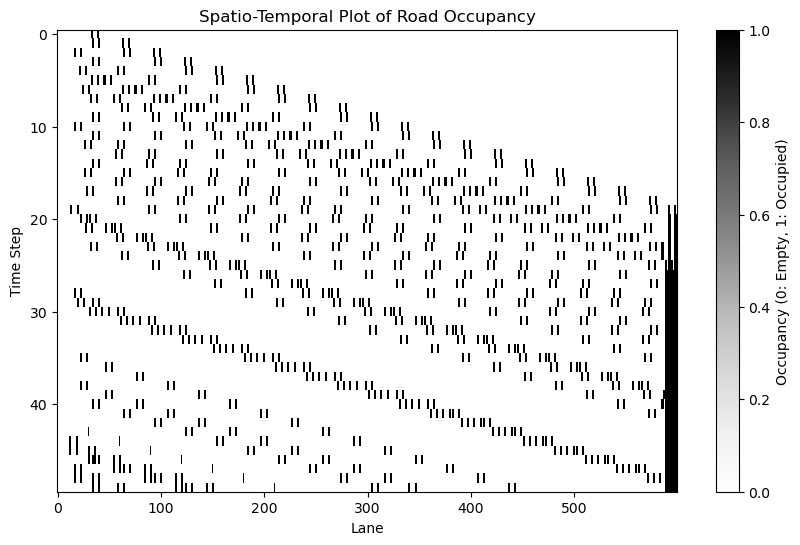

In [81]:
num_steps = 50
simulator.spatio_temporal_plot(num_steps)